## Preprocessing using glove embedding

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import gensim.downloader as api

# Load GloVe model with Gensim's API
embeddings_model = api.load("glove-twitter-200")  # 200-dimensional GloVe embeddings

# Read all training files and concatenate them into one dataframe
li = []
for filename in tqdm(os.listdir("train_tweets")):
    df = pd.read_csv("train_tweets/" + filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)
df = df.sample(n=500000, random_state=42)

100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


In [2]:
from challenge_data.glove_nn import preprocess_text, get_avg_embedding
import numpy as np

# Apply preprocessing to each tweet
df['Tweet'] = df['Tweet'].apply(preprocess_text)

# Apply preprocessing to each tweet and obtain vectors
vector_size = 200  # Adjust based on the chosen GloVe model
df['Embeddings'] = list(np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df['Tweet']]))

# Drop the columns that are not useful anymore
period_features = df.drop(columns=['Timestamp', 'Tweet'])

# Be sure to replace 'Embeddings' by the real name of the column containing embeddings
grouped = period_features.groupby(['MatchID', 'PeriodID', 'ID'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from challenge_data.glove_nn import compute_mean_and_max_concat

# Application of the function on each group to gat a list of lists
X = grouped.apply(lambda g: compute_mean_and_max_concat(g)).tolist()

y = grouped['EventType'].first().tolist()

# We split our data into a training and test set that we can use to train our classifier without fine-tuning into the
# validation set and without submitting too many times into Kaggle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_9788\3853459343.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = grouped.apply(lambda g: compute_mean_and_max_concat(g)).tolist()
C:\Users\HP\AppData\Local\Temp\ipykernel_9788\3853459343.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)


## The neural network

In [ ]:
import torch.nn as nn
import torch.optim as optim
from challenge_data.glove_nn import NeuralNet, train

torch.manual_seed(41)

# Hyperparameters
lr = 0.001
num_epochs = 100
slope = 0.01
model = NeuralNet(input_size=vector_size*2, slope=slope)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=lr) 
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # not usable right now

In [23]:
# Training
loss_list = train(num_epochs, model, train_loader, criterion, optimizer)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_list = []
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred_list.extend(outputs.numpy())

y_pred = (np.array(y_pred_list) > 0.5).astype(int)  # Adjust threshold for binary classification

# Print test set accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.26it/s]

Test set accuracy: 0.7133956386292835


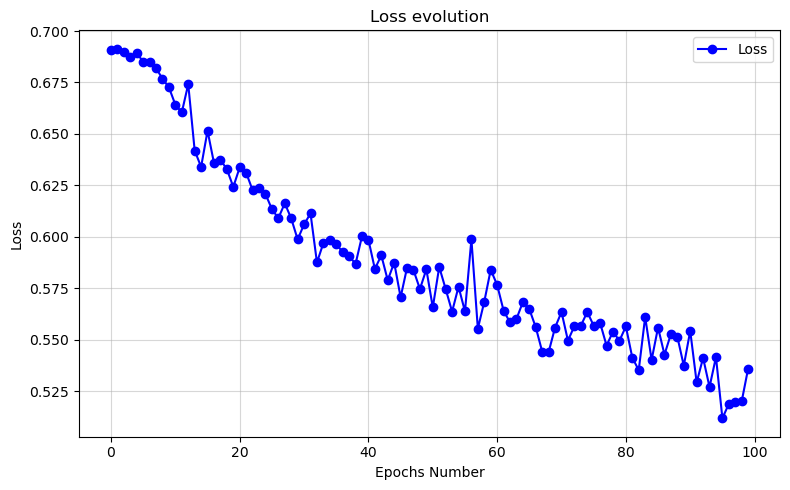

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.title("Loss evolution")
plt.xlabel("Epochs Number")
plt.ylabel("Loss")
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()